# One vs All Differential expression on Packer, Cao and Taylor C. elegans data using single-cell Variational Inference (scVI)


In [19]:
import scvi
scvi.__version__

'0.6.3'

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Control warnings
import warnings; warnings.simplefilter('ignore')

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scvi.dataset import GeneExpressionDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
import torch
import anndata

import plotly.express as px
import plotly.graph_objects as go



In [21]:
## Change the path where the models will be saved 
save_path = "./"

if os.path.isfile('wormcells-data-2020-03-30.h5ad'):
    print ("Found the data file! No need to download.")
else:
    print ("Downloading data...")
    ! https://github.com/Munfred/wormcells-site/releases/download/Packer2019Taylor2019Cao2019_wrangle2/wormcells-data-2020-03-30.h5ad


Found the data file! No need to download.


In [4]:
adata = anndata.read('wormcells-data-2020-03-30.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 191138 × 22761 
    obs: 'barcode', 'cell_subtype', 'cell_type', 'embryo_time', 'embryo_time_bin', 'experiment', 'lineage', 'numi', 'passed_qc', 'raw_embryo_time', 'raw_embryo_time_bin', 'size_factor', 'study', 'time_point', 'tissue_type'
    var: 'gene_name', 'gene_description'

In [6]:
adata.X

<191138x22761 sparse matrix of type '<class 'numpy.float32'>'
	with 124285259 stored elements in Compressed Sparse Row format>

### Take a look at the gene descriptions
The gene descriptions were taken using the [WormBase API](https://wormbase.org/about/userguide/for_developers#3--10).


In [7]:
display(adata.var.head(2).style.set_properties(subset=['gene_description'], **{'width': '600px'}))

,gene_name,gene_description
gene_id,,
WBGene00000001,aap-1,"Exhibits protein kinase binding activity. Involved in dauer larval development; determination of adult lifespan; and insulin receptor signaling pathway. Localizes to the phosphatidylinositol 3-kinase complex. Human ortholog(s) of this gene implicated in several diseases, including astroblastoma; carcinoma (multiple); endometrial cancer (multiple); primary immunodeficiency disease (multiple); and type 2 diabetes mellitus. Is expressed in intestine and neurons. Orthologous to several human genes including PIK3R3 (phosphoinositide-3-kinase regulatory subunit 3)."
WBGene00000002,aat-1,"Contributes to L-amino acid transmembrane transporter activity. Involved in amino acid transmembrane transport. Localizes to the amino acid transport complex. Is expressed in several structures, including excretory system; gonadal sheath cell; nervous system; pharynx; and rectal gland cell. Orthologous to several human genes including SLC7A8 (solute carrier family 7 member 8)."


In [8]:
adata.obs.head()

,barcode,cell_subtype,cell_type,embryo_time,embryo_time_bin,experiment,lineage,numi,passed_qc,raw_embryo_time,raw_embryo_time_bin,size_factor,study,time_point,tissue_type
0-cao,A01_A02_AACTACCGAC,nan,hyp_4_to_7_bin_3_around_L2_molt,NaN,nan,L2_experiment_1,nan,NaN,nan,NaN,nan,NaN,cao,nan,nan
1-cao,A01_A02_AACTACGGCT,nan,ASI,NaN,nan,L2_experiment_1,nan,NaN,nan,NaN,nan,NaN,cao,nan,nan
2-cao,A01_A02_AACTATTATA,nan,mu_sph,NaN,nan,L2_experiment_1,nan,NaN,nan,NaN,nan,NaN,cao,nan,nan
3-cao,A01_A02_AAGACGGCCA,nan,Germline,NaN,nan,L2_experiment_1,nan,NaN,nan,NaN,nan,NaN,cao,nan,nan
4-cao,A01_A02_AAGTTGCCAT,nan,Germline,NaN,nan,L2_experiment_1,nan,NaN,nan,NaN,nan,NaN,cao,nan,nan



## Loading data

Here, each experiment correspond to a batch.

In [9]:
gene_dataset = GeneExpressionDataset()

# we provide the `batch_indices` so that scvi can perform batch correction
gene_dataset.populate_from_data(
            adata.X,
            gene_names=adata.var.index.values,
            cell_types=adata.obs['cell_type'].values,
            batch_indices=adata.obs['experiment'].cat.codes.values,
            )

# We retrain all genes 
gene_dataset.filter_genes_by_count(per_batch=True)
sel_genes = gene_dataset.gene_names


[2020-04-30 19:44:29,070] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-30 19:44:29,076] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-30 19:44:29,510] INFO - scvi.dataset.dataset | Downsampling from 22761 to 7400 genes
[2020-04-30 19:44:31,255] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-30 19:44:31,554] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-04-30 19:44:32,904] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-30 19:44:33,192] INFO - scvi.dataset.dataset | Downsampled from 191138 to 191138 cells


In [10]:
adata.obs['cell_type'].values

[hyp_4_to_7_bin_3_around_L2_molt, ASI, mu_sph, Germline, Germline, ..., BDU, RIA, SMB, ASG, VB]
Length: 191138
Categories (342, object): [ABarpaaa_lineage, ADA?, ADA_ADE_grandparent, ADE, ..., pm6_and_possibly_pm7, pm7, pm8, rect_D]

## Define the model

* __n_epochs__: Maximum number of epochs to train the model.   
    If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_cuda__: Set to true to use CUDA (GPU required) 


We now create the model and the trainer object. We train the model and output model likelihood every epoch. In order to evaluate the likelihood on a test set, we split the datasets (the current code can also so train/validation/test).

If a pre-trained model already exist in the save_path then load the same model rather than re-training it. This is particularly useful for large datasets.

In [14]:
# for this dataset 5 epochs is sufficient 
n_epochs = 10
lr = 1e-3
use_cuda = False # we are loading a CPU trained model so this should be false

# set the VAE to perform batch correction
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches)

trainer = UnsupervisedTrainer(
    vae,
    gene_dataset,
    train_size=0.75, # number between 0 and 1, default 0.8
    use_cuda=use_cuda,
    frequency=1,
)

## Training or loading a pretrained model

Note that if you already have the file `CPT_vae_cpu2.pkl` it will load it instead of training from scratch

In [75]:
# download the model
vae_file_name = 'CPT_vae_cpu3.pkl'

if os.path.isfile('CPT_vae_cpu3.pkl'):
    print ("Found the pretrained model! No need to download")
else:
    print ("Downloading pretrained model...")
    ! https://github.com/Munfred/worm-notebooks/releases/download/CPT_vae_cpu_v3/CPT_vae_cpu3.pkl
        
        

Found the pretrained model! No need to download


In [16]:
# check if a previously trained model already exists, if yes load it

full_file_save_path = os.path.join(save_path, vae_file_name)

if os.path.isfile(full_file_save_path):
    trainer.model.load_state_dict(torch.load(full_file_save_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), full_file_save_path)

[2020-04-30 20:01:25,822] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-04-30 20:01:25,824] INFO - scvi.inference.inference | KL warmup for 400 epochs



[2020-04-30 21:23:49,573] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.



### Plotting the likelihood change across training


In [17]:
train_test_results = pd.DataFrame(trainer.history).rename(columns={'elbo_train_set':'Train', 'elbo_test_set':'Test'})

train_test_results

,Train,Test
0,12538.038968,12466.712955
1,1980.652337,1977.399635
2,1928.391457,1928.017037
3,1902.241703,1902.016955
4,1882.587995,1882.466128
5,1866.266035,1866.090033
6,1856.505079,1856.122612
7,1851.608431,1851.469275
8,1849.038867,1848.898976
9,1839.670509,1840.135183


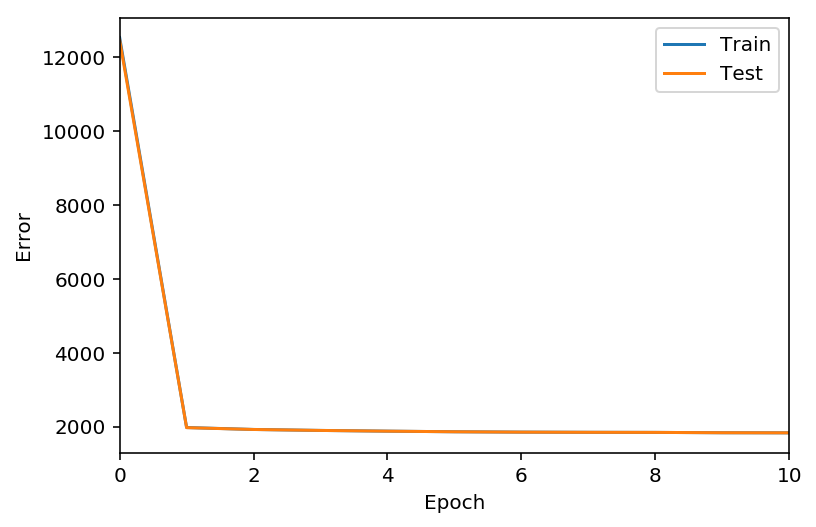

In [18]:
ax = train_test_results.plot()
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")
plt.show()



## Obtaining the posterior object and sample latent space

The posterior object contains a model and a gene_dataset, as well as additional arguments that for Pytorch's `DataLoader`. It also comes with many methods or utilities querying the model, such as differential expression, imputation and differential analyisis.


To get an ordered output result, we might use `.sequential` posterior's method which return another instance of posterior (with shallow copy of all its object references), but where the iteration is in the same ordered as its  indices attribute.

In [30]:
# scvi tutorial latent space code
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
latent.shape

(191138, 10)

In [31]:
# store the latent space in a new anndata object
post_adata = anndata.AnnData(X=gene_dataset.X)
post_adata.obs=adata.obs
post_adata.obsm["latent"] = latent
post_adata

AnnData object with n_obs × n_vars = 191138 × 7400 
    obs: 'barcode', 'cell_subtype', 'cell_type', 'embryo_time', 'embryo_time_bin', 'experiment', 'lineage', 'numi', 'passed_qc', 'raw_embryo_time', 'raw_embryo_time_bin', 'size_factor', 'study', 'time_point', 'tissue_type'
    obsm: 'latent'



### Selecting cells to compare

In [32]:
# let's take a look at abundances of different cell types
adata.obs['cell_type'].value_counts()[:30]

nan                           30326
BWM_posterior                  6825
VB                             6706
Coelomocyte                    6606
BWM_anterior                   6169
Germline                       6159
BWM_middle_and_posterior       3331
Body_wall_muscle               3091
Epidermis                      2888
Seam_cell                      2766
CAN                            2432
BWM_head_row_1                 2384
Hypodermis                     2288
BWM_head_row_2                 2106
RIA                            2067
SIA                            2022
DB                             1980
pm3_pm4_pm5                    1925
hyp7_C_lineage                 1774
ASG                            1582
AVK                            1534
ADL                            1473
Ciliated_non_amphid_neuron     1469
AIB                            1313
Intestine                      1217
BWM_far_posterior              1197
VC_1-3;6                       1172
VA_SAB                      

In [33]:
# let's pick two cell types
cell_type_1 = 'ADL'
cell_type_2 = 'AIB'


cell_idx1 = adata.obs['cell_type'] == cell_type_1
print(sum(cell_idx1), 'cells of type', cell_type_1)
cell_idx2 = adata.obs['cell_type'] == cell_type_2
print(sum(cell_idx2), 'cells of type', cell_type_2)

1473 cells of type ADL
1313 cells of type AIB


In [34]:
n_samples = 10000
M_permutation = 10000

In [36]:
de_vanilla = full.differential_expression_score(
    idx1 = cell_idx1.values, 
    idx2 = cell_idx2.values, 
    mode='vanilla', # vanilla is the default
    n_samples=n_samples, 
    M_permutation=M_permutation,
)

In [37]:
de_vanilla.head()

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
WBGene00000484,0.9998,0.0002,8.516543,0.000138,0.000004,0.254582,0.001523,0.186015,0.001523,1.902635,0.014351
WBGene00019395,0.9997,0.0003,8.110995,0.000215,0.000003,0.353700,0.001523,0.250509,0.001523,2.337339,0.011882
WBGene00022503,0.9997,0.0003,8.110995,0.000510,0.000022,1.171083,0.001523,0.429056,0.001523,7.736886,0.007626
WBGene00000242,0.9995,0.0005,7.599982,0.000441,0.000006,0.641550,0.002285,0.340122,0.002285,4.354659,0.018804
WBGene00021416,0.9994,0.0006,7.417564,0.000754,0.000019,2.108622,0.009139,0.540394,0.006855,14.367755,0.082081




## Heatmap of top expressed genes for `vanilla` mode

Now we perform DE between each cell type vs all other cells and make a heatmap of the result.

First we need to make cell type sumary with numerical codes for each cell type

In [39]:
# we need to numerically encode the cell types for passing the cluster identity to scVI
cell_code_to_type = dict( zip( adata.obs['cell_type'].cat.codes, adata.obs['cell_type'] ) )
cell_type_to_code_map = dict([[v,k] for k,v in cell_code_to_type.items()])
# check that we got unique cell type labels
assert len(cell_code_to_type)==len(cell_type_to_code_map)

cell_types_summary=pd.DataFrame(index=adata.obs['cell_type'].value_counts().index)
cell_types_summary['cell_type_code']=cell_types_summary.index.map(cell_type_to_code_map)
cell_types_summary['ncells']=adata.obs['cell_type'].value_counts()
cell_types_summary['cell_type_name']=adata.obs['cell_type'].value_counts().index
cell_types_summary.to_csv('packer_cell_types_summary.csv')
cell_types_summary.head()

,cell_type_code,ncells,cell_type_name
nan,334,30326,nan
BWM_posterior,83,6825,BWM_posterior
VB,297,6706,VB
Coelomocyte,92,6606,Coelomocyte
BWM_anterior,76,6169,BWM_anterior


In [41]:
# create a column in the cell data with the cluster id each cell belongs to
adata.obs['cell_type_code'] = adata.obs['cell_type'].cat.codes

In [42]:
adata.obs['cell_type_code'].ravel()

array([328,  41, 333, ..., 266,  37, 297], dtype=int16)

In [43]:
cell_types_summary.head(30)

,cell_type_code,ncells,cell_type_name
nan,334,30326,nan
BWM_posterior,83,6825,BWM_posterior
VB,297,6706,VB
Coelomocyte,92,6606,Coelomocyte
BWM_anterior,76,6169,BWM_anterior
Germline,115,6159,Germline
BWM_middle_and_posterior,81,3331,BWM_middle_and_posterior
Body_wall_muscle,85,3091,Body_wall_muscle
Epidermis,104,2888,Epidermis
Seam_cell,271,2766,Seam_cell


In [44]:
adata.obs['cell_type_code'].ravel()

array([328,  41, 333, ..., 266,  37, 297], dtype=int16)

In [50]:
# lets select ASG cells which have code 37
chosen_cells_mask = adata.obs['cell_type_code']==37
chosen_cells_mask

0-cao           False
1-cao           False
2-cao           False
3-cao           False
4-cao           False
                ...  
65445-taylor    False
65446-taylor    False
65447-taylor    False
65448-taylor     True
65449-taylor    False
Name: cell_type_code, Length: 191138, dtype: bool

In [59]:
len(chosen_cells_mask.values)

191138

In [60]:
len(gene_dataset)

191138

In [65]:
# this returns a list of dataframes with DE results (one for each cluster),
# and a list with the corresponding cluster id
vanilla_per_cluster_de, vanilla_cluster_id = full.one_vs_all_degenes(
#     subset=chosen_cells_mask.values,
    cell_labels=adata.obs['cell_type_code'].ravel(), 
    mode = 'vanilla', # vanilla is the default mode
    min_cells=100)

In [69]:
type(vanilla_per_cluster_de)

list

In [70]:
len(vanilla_per_cluster_de)

243

# DE results for chosen cluster

In [72]:
vanilla_per_cluster_de[37]

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
WBGene00001451,0.919368,0.080632,2.433787,0.006313,0.000905,64.196571,0.791975,0.751724,0.024685,641.700745,3.819703,47
WBGene00018298,0.914166,0.085834,2.365593,0.004677,0.000822,0.251724,0.955699,0.067241,0.077462,1.789379,7.298349,47
WBGene00018774,0.911765,0.088235,2.335375,0.001024,0.000249,0.015517,0.012479,0.015517,0.005657,0.177101,0.091942,47
WBGene00021116,0.907363,0.092637,2.281853,0.000175,0.000056,0.008621,0.016478,0.008621,0.013649,0.088533,0.161235,47
WBGene00045336,0.907163,0.092837,2.279475,0.001813,0.000476,0.025862,0.108974,0.008621,0.018278,0.273217,1.333389,47
...,...,...,...,...,...,...,...,...,...,...,...,...
WBGene00004795,0.158663,0.841337,-1.668206,0.000009,0.000022,0.000000,0.018147,0.000000,0.014489,0.000000,0.077716,47
WBGene00006876,0.154862,0.845138,-1.696966,0.000058,0.000161,0.017241,0.370496,0.015517,0.148564,0.136002,2.223302,47
WBGene00007047,0.152861,0.847139,-1.712335,0.000035,0.000075,0.010345,0.131385,0.010345,0.092728,0.101900,0.555494,47
WBGene00016422,0.152261,0.847739,-1.716977,0.000027,0.000293,0.013793,1.112879,0.012069,0.106477,0.116629,3.803466,47




## Code for making interactive heatmap (needs to be changed a bit)
